In [1]:
import nest_asyncio
nest_asyncio.apply()
import cmdstanpy as sp
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler
import matplotlib.patches as mpatches
plt.rcParams["xtick.minor.visible"] =  True
plt.rcParams["ytick.minor.visible"] =  True
plt.rcParams["mathtext.fontset"]="cm"
plt.rcParams['errorbar.capsize'] = 3
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=22
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle']=':'
plt.rcParams['grid.color']='black'
plt.rcParams['axes.prop_cycle'] = cycler(color=['black', 'red', 'blue', 'green'])

import arviz as az
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("linear_model.txt",delimiter='\t',header=None)
data.columns=['x','y','dy']

In [3]:
def f(x,a,b):
    return a*np.cos(x)+b
def f1(x,a,b,c):
    return a*np.cos(x+c)+b

popt, pcov = curve_fit(f,data['x'].values,data['y'].values,p0=[2,2],sigma=data['dy'].values)
popt1, pcov1 = curve_fit(f1,data['x'].values,data['y'].values,p0=[2,2,0],sigma=data['dy'].values)

In [4]:
model = sp.CmdStanModel(stan_file='./stan_file.stan')
print(model.code())

INFO:cmdstanpy:compiling stan program, exe file: /home/jakob/Documents/Studium/master_thesis/bayes/first_model/stan_file
INFO:cmdstanpy:compiler options: stanc_options={}, cpp_options={}
INFO:cmdstanpy:compiled model file: /home/jakob/Documents/Studium/master_thesis/bayes/first_model/stan_file


data {
	int<lower=0> n;
	vector[n] x;
	vector[n] y;
	vector[n] dy;
}
parameters {
	real a;
	real b;
}

model {
	y ~ normal(b + a * cos(x), dy);
	a ~ normal(0,100);
	b ~ normal(0,100);
}
generated quantities {
	real y_tilde[n] = normal_rng(b + a * cos(x),dy);
	vector[n] log_lik;
	vector[n] mu;
	mu=b+a*cos(x);
	for (k in 1:n){
    	log_lik[k]=normal_lpdf(y[k]|mu[k], dy[k]);
    }
}



In [5]:
stan_data={'n':len(data['x'].values),
             'x':list(data['x'].values),
             'y':list(data['y'].values),
           'dy':list(data['dy'].values)
}

fit = model.sample(data=stan_data)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1


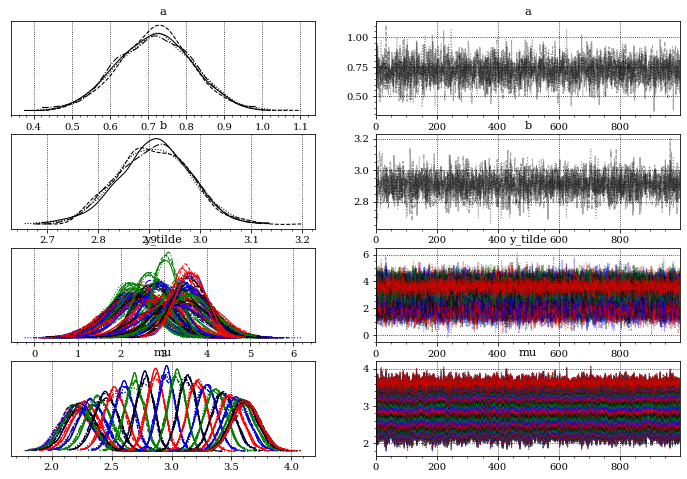

In [6]:
%%capture --no-display
warnings.filterwarnings('ignore')
az.plot_trace(fit)
plt.show()

In [7]:
samples=fit.draws_pd()
samples

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,a,b,y_tilde[1],...,mu[41],mu[42],mu[43],mu[44],mu[45],mu[46],mu[47],mu[48],mu[49],mu[50]
0,-1.256530,0.833464,0.875291,1.0,3.0,0.0,2.657670,0.715591,2.98269,2.88133,...,3.20382,3.28737,3.36612,3.43882,3.50433,3.56161,3.60976,3.64803,3.67580,3.69264
1,-1.349840,0.979207,0.875291,2.0,3.0,0.0,1.801510,0.805664,2.85490,3.95665,...,3.10386,3.19793,3.28659,3.36845,3.44220,3.50669,3.56091,3.60398,3.63525,3.65421
2,-0.918983,0.981462,0.875291,2.0,3.0,0.0,1.681920,0.702801,2.86466,3.18240,...,3.08184,3.16390,3.24124,3.31264,3.37698,3.43324,3.48053,3.51811,3.54538,3.56192
3,-0.743926,0.882675,0.875291,2.0,3.0,0.0,1.984410,0.686271,2.91250,4.02137,...,3.12457,3.20470,3.28022,3.34995,3.41277,3.46771,3.51389,3.55058,3.57721,3.59336
4,-3.388620,0.759881,0.875291,2.0,3.0,0.0,3.408280,0.946697,2.89251,3.75350,...,3.18506,3.29560,3.39978,3.49596,3.58262,3.65841,3.72211,3.77273,3.80947,3.83174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-0.730999,0.985071,0.843690,2.0,3.0,0.0,0.831905,0.711137,2.92654,3.13718,...,3.14630,3.22933,3.30759,3.37984,3.44494,3.50186,3.54972,3.58774,3.61534,3.63207
3996,-1.071400,0.886822,0.843690,2.0,3.0,0.0,1.763790,0.633392,2.89743,4.24738,...,3.09316,3.16712,3.23682,3.30117,3.35916,3.40986,3.45248,3.48635,3.51093,3.52583
3997,-1.177230,0.996749,0.843690,3.0,7.0,0.0,1.188640,0.804044,2.93233,4.43084,...,3.18080,3.27468,3.36316,3.44485,3.51846,3.58282,3.63692,3.67991,3.71112,3.73004
3998,-1.108870,0.992062,0.843690,3.0,7.0,0.0,1.542270,0.790162,2.86886,3.69226,...,3.11303,3.20530,3.29225,3.37253,3.44486,3.50812,3.56128,3.60353,3.63420,3.65279


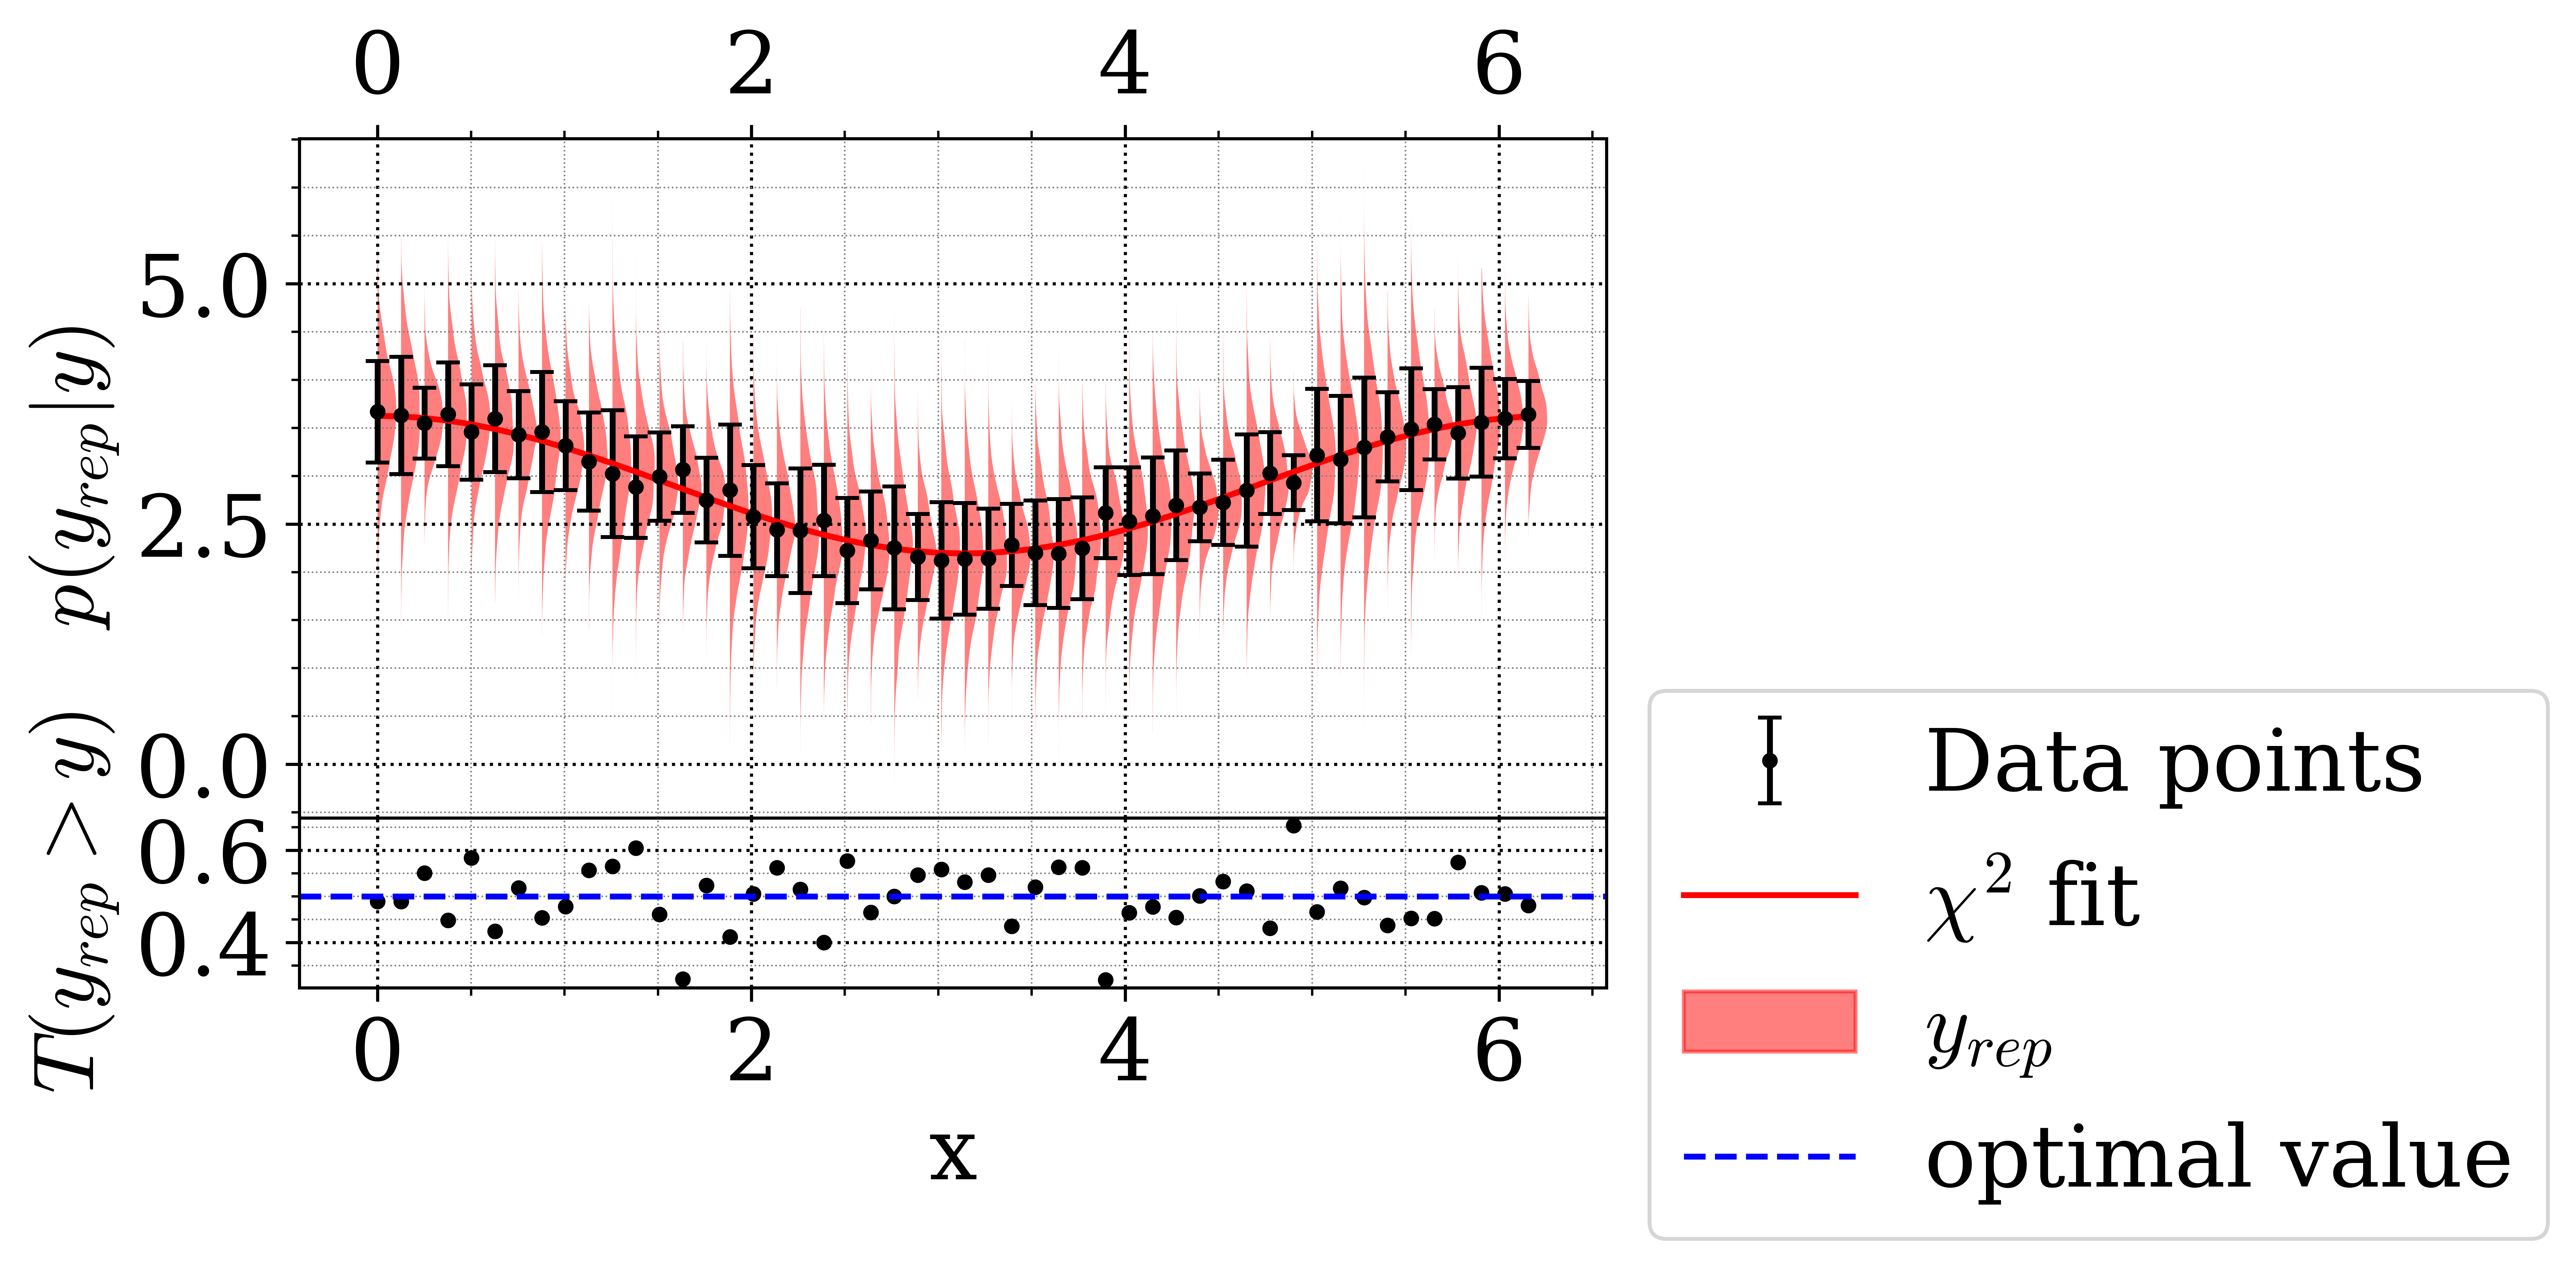

In [8]:
#cosmetics
fig, (ax, ax1)=plt.subplots(nrows=2,sharex=True,dpi=1000,gridspec_kw={'height_ratios': [4, 1]})
ax.set_ylabel('$p(y_{rep}|y)$')
ax.xaxis.set_ticks_position("top")
ax.grid(which='minor',color='grey',lw='.4')
#get results from chisq fit and plot them
yfit=f(data['x'],*popt)
ax.errorbar(x=data['x'],y=data['y'],yerr=data['dy'],fmt='.',label='Data points')
#ax.plot(data['x'],data['y'],'x',label='Data points')
ax.plot(data['x'],yfit,'r-',label='$\chi^2$ fit',color='r')
#violinplot for the replicated samples
vp=ax.violinplot([samples[f'y_tilde[{i+1}]']for i in range(50)],data['x'],showmeans=False, showextrema=False, showmedians=False,widths=0.2)
#cosmetics
for b in vp['bodies']:
    # get the center
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further right than the center
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
    b.set_alpha(.5)
    #b.set_color('red')

#compute p value as measure of goodness of fit
y_arr=[samples[f'y_tilde[{i+1}]']for i in range(50)]
pvalue=[len([y for y in y_arr[i] if y>=data['y'][i]])/len(y_arr[i])for i in range(50)]
#plot pvalue
ax1.grid(which='minor',color='grey',lw='.4')
ax1.plot(data['x'],pvalue,'.')
ax1.axhline(y=0.5, color='b', linestyle='--',label='optimal value')
ax1.set_xlabel('x')
ax1.set_ylabel('$T(y_{rep}>y)$')
#cosmetics and legend
plt.subplots_adjust(wspace=0, hspace=0)
lines,labels = ax.get_legend_handles_labels() 
patch = mpatches.Patch(color='red', label='$y_{rep}$',alpha=.5)
lines.append(patch)
lines1,labels1=ax1.get_legend_handles_labels()
lines+=lines1
tmp=lines[0]
lines[0]=lines[1]
lines[1]=tmp
plt.legend(handles=lines,bbox_to_anchor=(1,2))
plt.savefig('plot.pdf',format='pdf',bbox_inches='tight',dpi=1000)


(array([ 2.,  0.,  2.,  7.,  9., 12.,  7.,  9.,  1.,  1.]),
 array([0.319  , 0.35245, 0.3859 , 0.41935, 0.4528 , 0.48625, 0.5197 ,
        0.55315, 0.5866 , 0.62005, 0.6535 ]),
 <BarContainer object of 10 artists>)

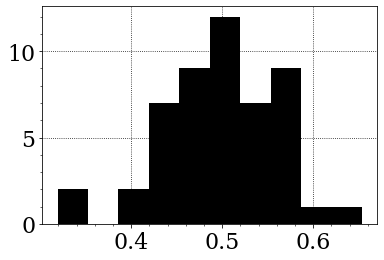

In [9]:
plt.hist(pvalue)

In [10]:
pwaic=sum([np.var(samples[f'log_lik[{i+1}]'], ddof=1)for i in range(50)])
lpd=sum([np.log(np.mean(np.exp(samples[f'log_lik[{i+1}]'])))for i in range(50)])
print(lpd-pwaic)

-14.428818196926406


In [11]:
print(pwaic)

0.1115298658534721


In [12]:
model1= sp.CmdStanModel(stan_file='./stan_file1.stan')
fit1 = model1.sample(data=stan_data)
fit1.summary()
samples1=fit1.draws_pd()

INFO:cmdstanpy:compiling stan program, exe file: /home/jakob/Documents/Studium/master_thesis/bayes/first_model/stan_file1
INFO:cmdstanpy:compiler options: stanc_options={}, cpp_options={}
INFO:cmdstanpy:compiled model file: /home/jakob/Documents/Studium/master_thesis/bayes/first_model/stan_file1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3


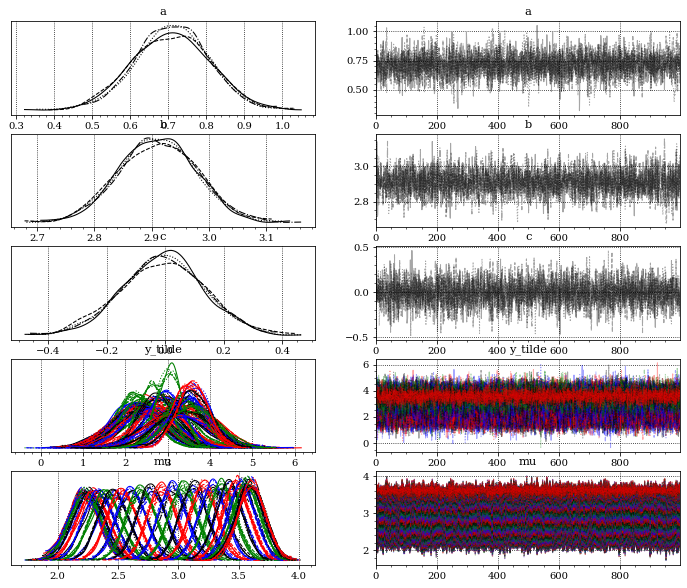

In [13]:
az.plot_trace(fit1)
plt.show()

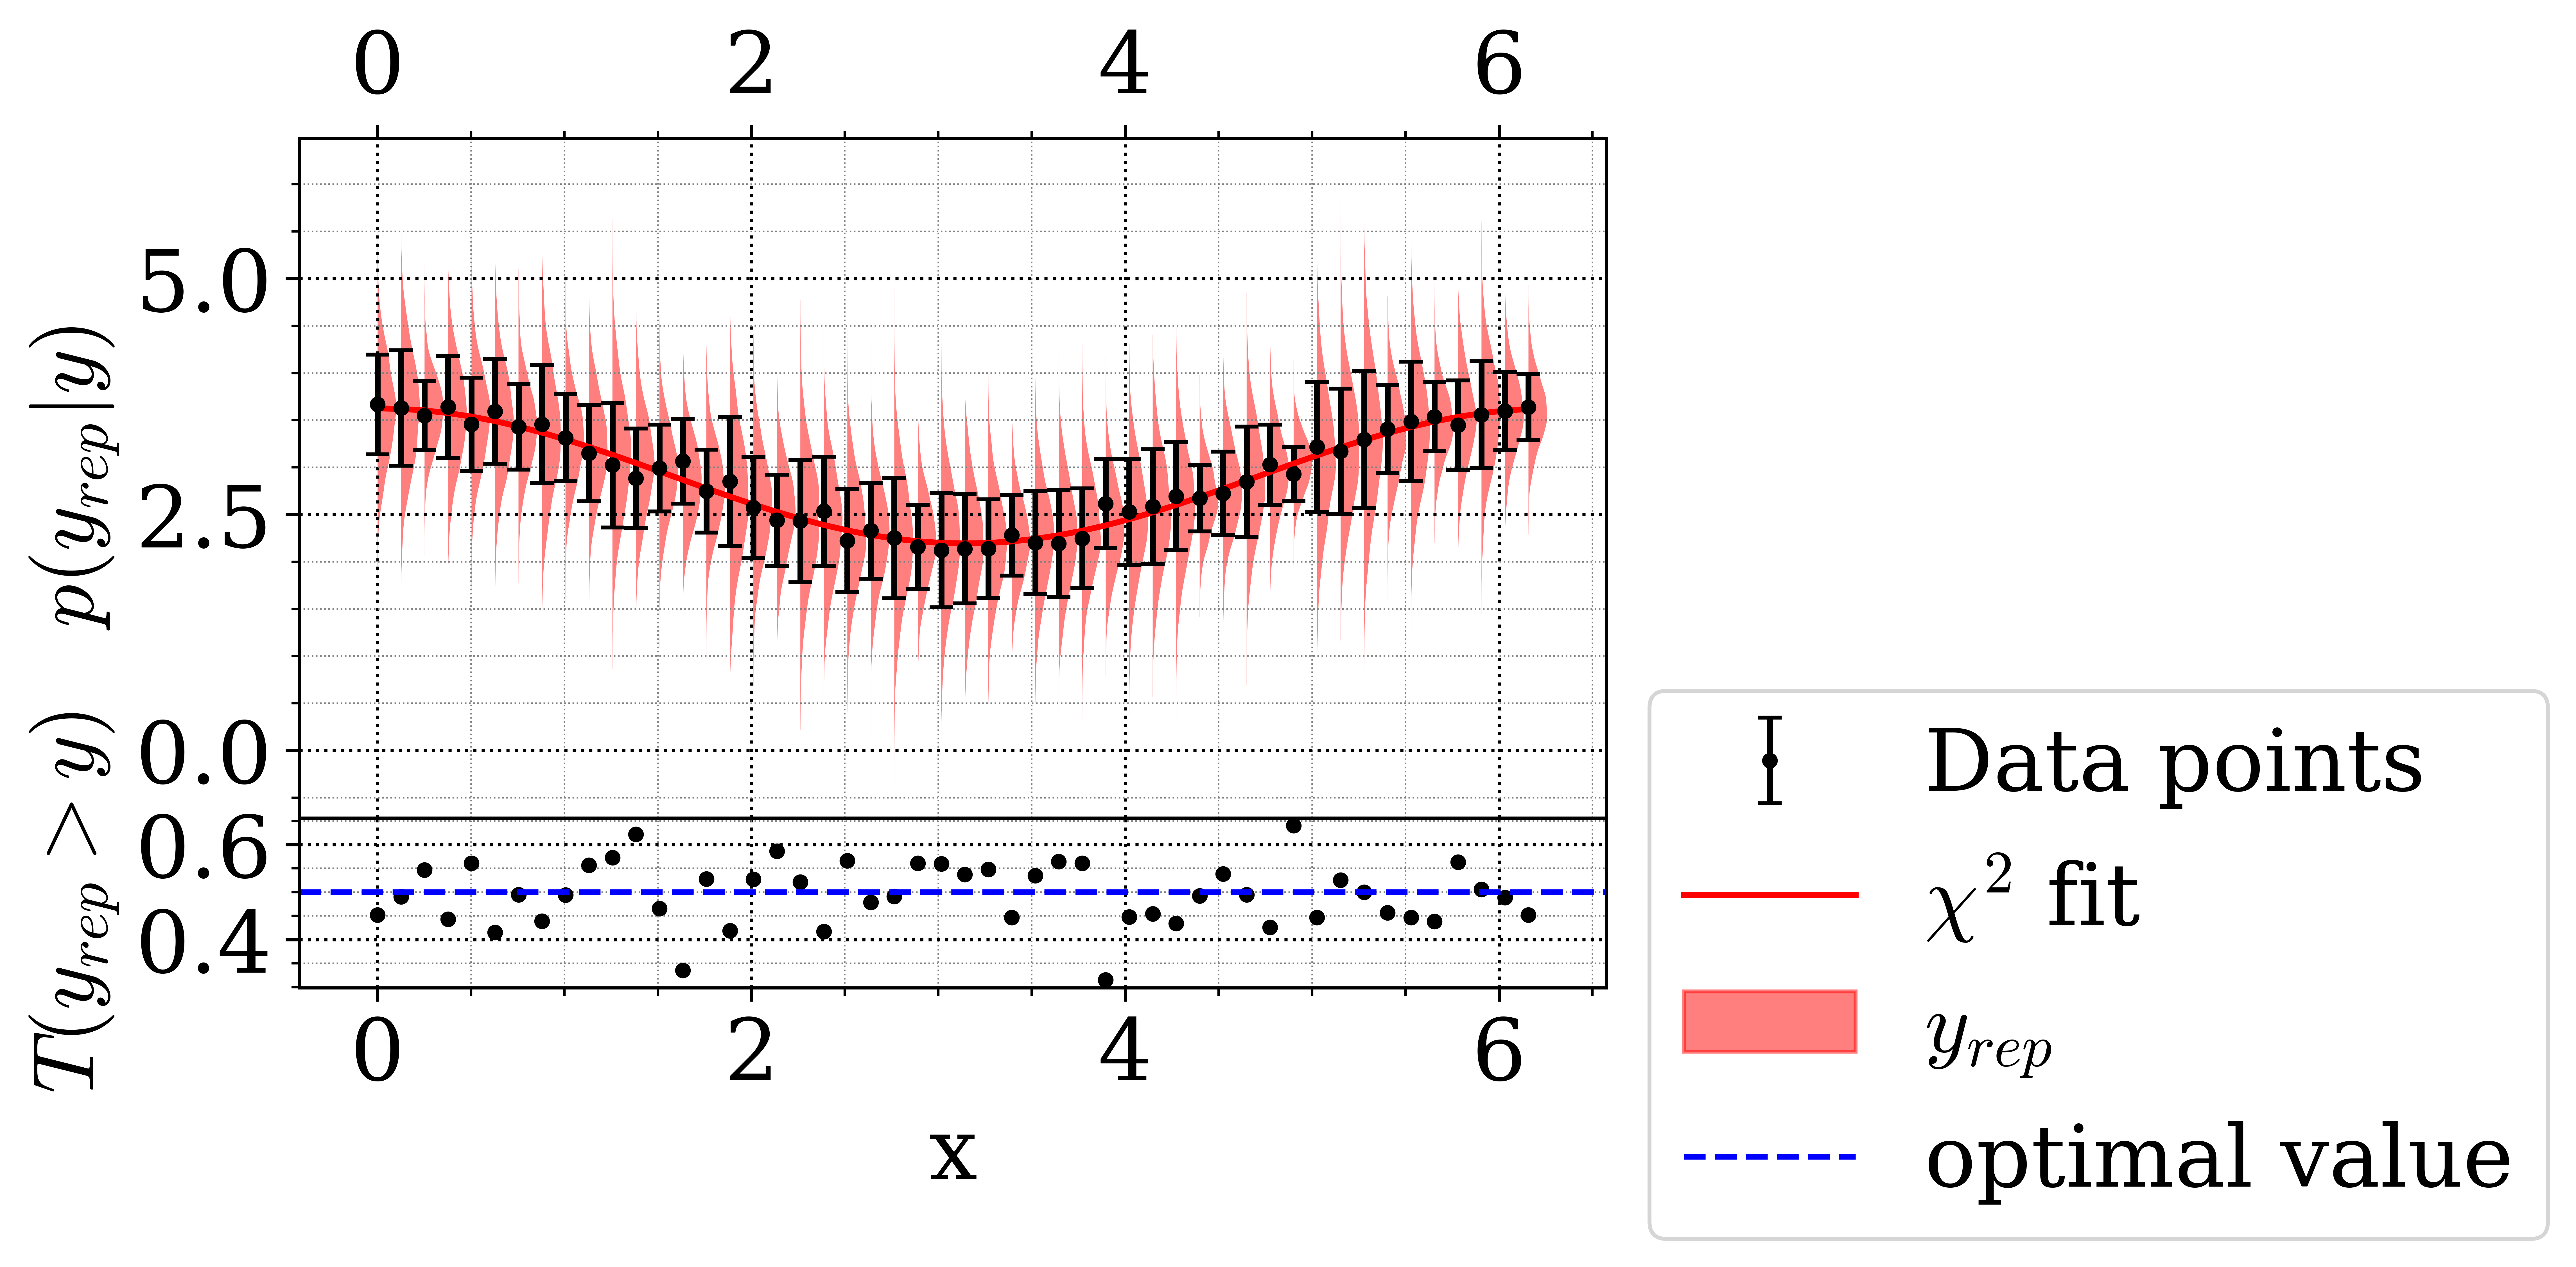

In [14]:
#cosmetics
fig, (ax, ax1)=plt.subplots(nrows=2,sharex=True,dpi=1000,gridspec_kw={'height_ratios': [4, 1]})
ax.set_ylabel('$p(y_{rep}|y)$')
ax.xaxis.set_ticks_position("top")
ax.grid(which='minor',color='grey',lw='.4')
#get results from chisq fit and plot them
yfit1=f1(data['x'],*popt1)
ax.errorbar(x=data['x'],y=data['y'],yerr=data['dy'],fmt='.',label='Data points')
#ax.plot(data['x'],data['y'],'x',label='Data points')
ax.plot(data['x'],yfit1,'r-',label='$\chi^2$ fit',color='r')
#violinplot for the replicated samples
vp=ax.violinplot([samples1[f'y_tilde[{i+1}]']for i in range(50)],data['x'],showmeans=False, showextrema=False, showmedians=False,widths=0.2)
#cosmetics
for b in vp['bodies']:
    # get the center
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further right than the center
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
    b.set_alpha(.5)
    #b.set_color('red')

#compute p value as measure of goodness of fit
y_arr=[samples1[f'y_tilde[{i+1}]']for i in range(50)]
pvalue=[len([y for y in y_arr[i] if y>=data['y'][i]])/len(y_arr[i])for i in range(50)]
#plot pvalue
ax1.grid(which='minor',color='grey',lw='.4')
ax1.plot(data['x'],pvalue,'.')
ax1.axhline(y=0.5, color='b', linestyle='--',label='optimal value')
ax1.set_xlabel('x')
ax1.set_ylabel('$T(y_{rep}>y)$')
#cosmetics and legend
plt.subplots_adjust(wspace=0, hspace=0)
lines,labels = ax.get_legend_handles_labels() 
patch = mpatches.Patch(color='red', label='$y_{rep}$',alpha=.5)
lines.append(patch)
lines1,labels1=ax1.get_legend_handles_labels()
lines+=lines1
tmp=lines[0]
lines[0]=lines[1]
lines[1]=tmp
plt.legend(handles=lines,bbox_to_anchor=(1,2))
plt.savefig('plot1.pdf',format='pdf',bbox_inches='tight',dpi=1000)

In [15]:
pwaic1=sum([np.var(samples1[f'log_lik[{i+1}]'], ddof=1)for i in range(50)])
lpd1=sum([np.log(np.mean(np.exp(samples1[f'log_lik[{i+1}]'])))for i in range(50)])
print(lpd1-pwaic1)

-14.941143681786468
